<a href="https://colab.research.google.com/github/replyeshab/speech-emotion-recognition/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import torchaudio
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import Wav2Vec2Model,Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2ForSequenceClassification

In [ ]:
import zipfile
import os

# Define the path to your ZIP file
zip_file_path = '/content/archive (5).zip'

# Unzip the file to a directory
extracted_folder_path = '/content/extracted_files'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Initialize lists to store file paths and labels
paths = []
labels = []

# Walk through the extracted directory to collect file paths and labels
for dirname, _, filenames in os.walk(extracted_folder_path):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        paths.append(file_path)

        # Assuming labels are encoded in the file name as per your original code
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())

        if len(paths) == 5000:
            break

# Now paths and labels are populated
print(paths[:5])  # Print first 5 paths to verify
print(labels[:5])  # Print first 5 labels to verify

In [ ]:
df= pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label


In [ ]:
df['label'].value_counts()

,count
label,


<Axes: >

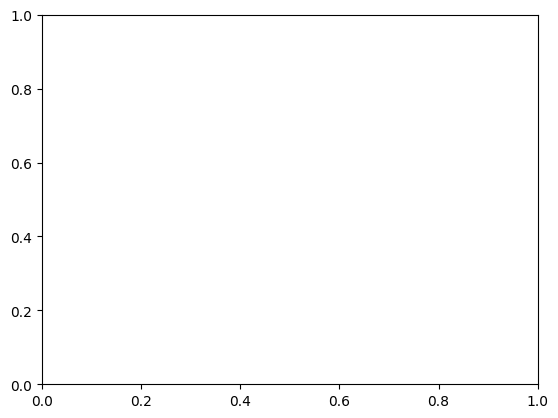

In [ ]:
df['label'] = df['label'].astype(str)
df['label'] = df['label'].fillna('Unknown')
sns.countplot(data=df, x='label')

In [ ]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size =20)
    librosa.display.waveplot(data,sr=sr)
    plt.show()
def spectrogram(data,sr,emotion):
    x = librosa.stft(data)
    xdb =librosa.power_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis ='time',y_axis ='hz')
    plt.colorbar()
    plt.show()

In [ ]:
emotion = 'fear'
path = df['speech'][df['label'] == emotion].iloc[0]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
emotion = 'angry'
path = df['speech'][df['label'] == emotion].iloc[1]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
emotion = 'sad'
path = df['speech'][df['label'] == emotion].iloc[0]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
emotion = 'disgust'
path = df['speech'][df['label'] == emotion].iloc[0]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
emotion = 'neutral'
path = df['speech'][df['label'] == emotion].iloc[0]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
emotion = 'happy'
path = df['speech'][df['label'] == emotion].iloc[0]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
emotion = 'ps'
path = df['speech'][df['label'] == emotion].iloc[0]
data, sampling_rate = librosa.load(path)

# Use librosa.display.waveshow() to plot the waveform
librosa.display.waveshow(data, sr=sampling_rate)
plt.title(f"Waveform of Emotion: {emotion}")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Call spectrogram function if required
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)

In [ ]:
label_map = {label:idx for idx,label in enumerate(df['label'].unique())}
inverse_label_map = {idx:label for label,idx in label_map.items()}
df['label'] = df['label'].map(label_map)
df.head()

In [ ]:
class SpeechEmotionDataset(Dataset):
    def __init__(self,df,processor,max_length =40000):
        self.df = df
        self.precessor = processor
        self.max_length = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['label']
        speech,sr = librosa.load(audio_path,sr = 20000)
        if len(speech)>self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech,(0,self.max_length-len(speech)),'constant')
        inputs = self.processor(speech,sampling_rate = 20000,return_tensors = 'pt',padding= True,truncate = True,max_lebgth =self.max_length)
        input_values = inputs.input_values.squeeze()
        return {'input_values':input-values,labels:torch.tensor(label,dtype=torch.long)}

In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size = 0.2,random_state = 42)

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-large-xlsr-53')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-large-xlsr-53', num_labels=7)

In [ ]:
train_dataset = SpeechEmotionDataset(train_df,processor)
test_dataset = SpeechEmotionDataset(test_df,processor)

In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size = 10,shuffle = True)
test_dataloader = DataLoader(test_dataset,batch_size = 10,shuffle = False)

In [ ]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 3,
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    evaluation_strategy = 'epoch',
    weight_decay = 0.01,
    report_to = []
)

In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = np.argmax(pred.predictions,axis = 1)
  acc = accuracy_score(labels,preds)
  precision ,recall,f1,_ = precision_recall_fscore_support(labels,preds,average = 'weightage')
  return {
      'accuracy':acc,
      'f1':f1,
      'precision':precision,
      'recall':recall
  }

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)
trainer.train()

In [ ]:
results = trainer.evaluate()
print(results)

In [ ]:
import random
idx = random.randrange(0,len(test_dataset))
print("Original Label:",inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')
with torch.no_grad():
  outputs = model(input_values)
logits = outputs.logits
predicted_calss = logits.argmax(dim=-1).item()
print('Predicted Label:',inverse_label_map[predicted_class])